In [36]:
import pandas as pd
import keras
from keras import Model, Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

## Predictive Model 

We use the Samsung health dataset to train and predict future walking/jogging distances of a given user. This will help inform whether the user is on track to meet their goal by a given time-frame. 

  

The predictive model is created using pyTorch.

In [75]:
# make predictions on differences to ensure accurate performance of the model 

data = pd.read_csv('/Users/aayush/Documents/Run4It/Run4It/Model/Data/samsung_dataset.csv')
orig_dist = data[['date', 'distance']]

data['diff'] = data['distance'].diff()
data['diff'][0] = data['distance'][0]

orig_dist['date'] = pd.to_datetime(data['date'])
data['date'] = pd.to_datetime(data['date'])

data = data.set_index('date')
data = data[['diff']]

std = StandardScaler()
data.head()

/Users/aayush/azuredatastudio-python/0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,diff
date,
2020-03-24,726.070
2020-03-25,391.360
2020-03-26,610.830
2020-03-27,1115.670
2020-03-28,1672.632


In [71]:
lookback = 5
nfeatures = data.shape[1]
n_splits = 3

# reshape data to (n_samples, n_timesteps, n_features)
def input_to_3d(data):
    return np.reshape(data, (data.shape[0], data.shape[1], nfeatures))

# build X input and Y target variables
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, :]
        X.append(a)
        Y.append(dataset[i, :])
    return input_to_3d(np.array(X)), np.array(Y)


# split into training and testing sets
train, test = data.loc['2020-03-24':'2021-01-01'], data.loc['2021-01-01':]

std.fit(train)
train = std.transform(train)
test = std.transform(test)
x_train, y_train = create_dataset(train, lookback)
x_test, y_test = create_dataset(test, lookback)



print(f'x shape: {x_train.shape}')
print(f'y shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x shape: (279, 5, 1)
y shape: (279, 1)
x_test shape: (71, 5, 1)
y_test shape: (71, 1)


In [72]:
#Build the LSTM model
class ForecastLSTM(Model):
    # Initialise variables
    def __init__(self, lstm_units, dense_units, input_shape):
        super(ForecastLSTM, self).__init__()
        self.lstm_units = lstm_units
        self.dense_units = dense_units

        self.model = self.build(input_shape)
        self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Build model
    def build(self, input_shape):
        model = Sequential()
        
        # add layers automatically
        if len(self.lstm_units) > 1:
            # return_sequences=True is required if we are passing the hidden outputs to another LSTM layer
            model.add(LSTM(self.lstm_units[0], return_sequences=True, input_shape=input_shape))
            
            for idx, unit in enumerate(self.lstm_units[1:]):
                if idx < (len(self.lstm_units)-2):
                    model.add(LSTM(unit, return_sequences=True))
                else:
                    model.add(LSTM(unit, return_sequences=False))
        
        # return_sequences needs to be False if we are returning to a dense layer 
        else:
            model.add(LSTM(self.lstm_units[0], return_sequences=False, input_shape=input_shape))
        
        # adding the dense layers requested
        for unit in self.dense_units:
            model.add(Dense(unit))
            
        # adding final output layer
        model.add(Dense(1))
        return model
    
    def cross_validate(self, X, y, n_splits=3):
        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        all_scores = []
        # Iterate over different folds and evaluate scores
        for train_index, val_index in tscv.split(X):
            x_train, x_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # fits on validation set
            self.model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_val, y_val), verbose=0)
            y_pred = self.model.predict(y_test)
            y_pred = transformer.inverse_transform(y_pred)
            y_val = transformer.inverse_transform(y_val)
            
            err = np.sqrt(mean_squared_error(y_pred, y_val))
            # gets score defined in the metrics field of .compile()
            
            all_scores.append(err)
        
        print(f'Min mse across folds: {min(all_scores)}')
        return min(all_scores)
    
model = ForecastLSTM([1024, 512, 256, 128], [180,64], input_shape=(x_train.shape[1], x_train.shape[2]))
model.model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), verbose=0)
model.model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 5, 1024)           4202496   
_________________________________________________________________
lstm_35 (LSTM)               (None, 5, 512)            3147776   
_________________________________________________________________
lstm_36 (LSTM)               (None, 5, 256)            787456    
_________________________________________________________________
lstm_37 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_33 (Dense)             (None, 180)               23220     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                11584     
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

In [73]:
# Lets predict with the model
y_pred = model.model.predict(x_test)

print(y_test.shape)
print(y_pred.shape)


# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {}'.format(score_rmse))

(71, 1)
(71, 1)
RMSE: 0.935921539234795


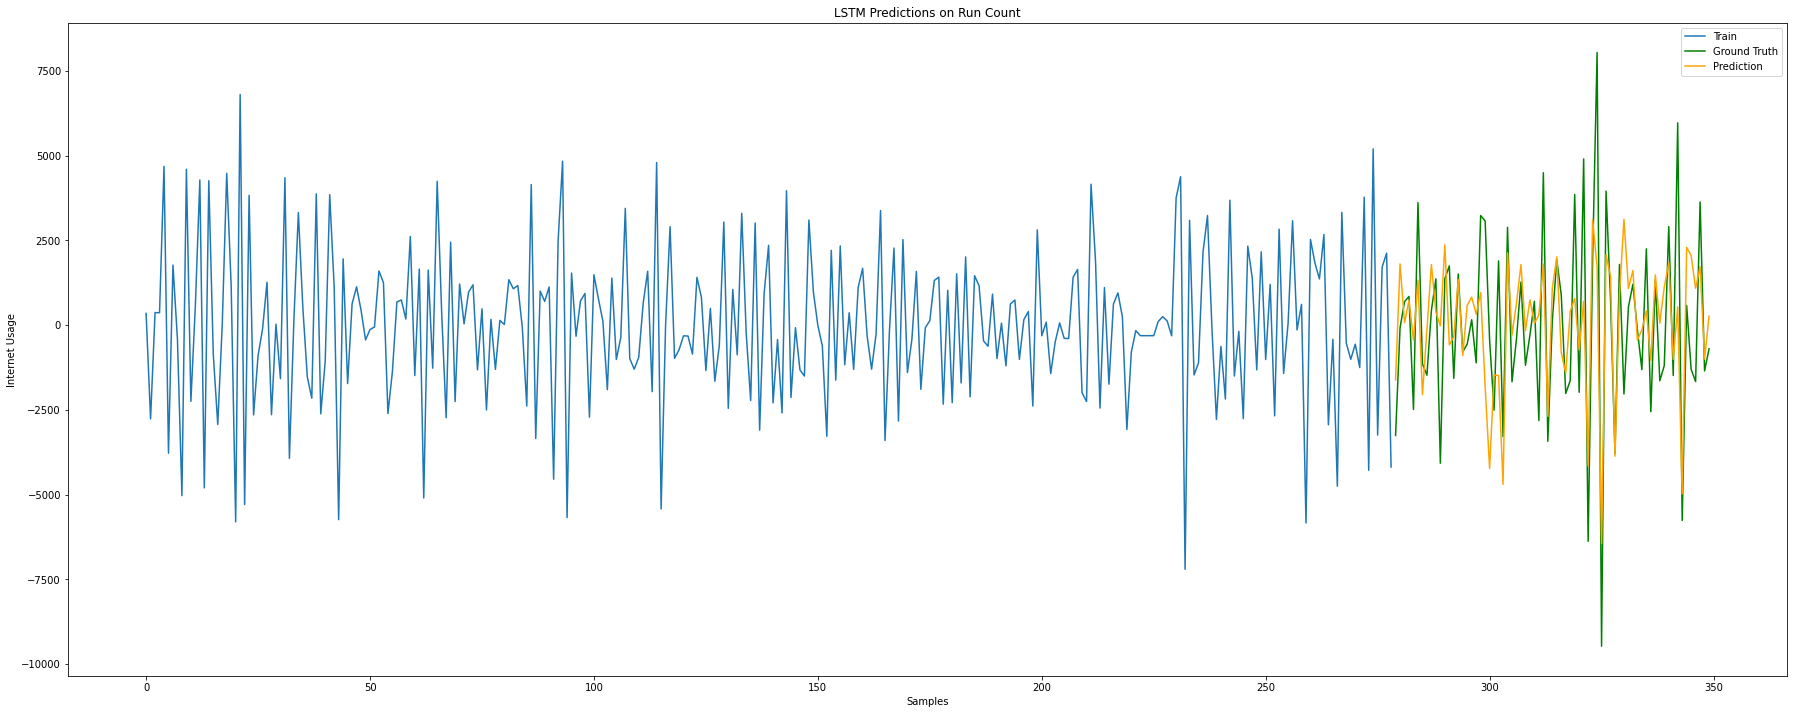

In [74]:
# Visualise outputs 
def plot_results(y_train, y_pred, y_true, n_features=2, height=15, title=None, nmf_flag=False):
    fig, ax = plt.subplots(n_features, figsize=(25,height))
    train_ticks = np.arange(0,y_train.shape[0])
    test_ticks = np.arange(y_train.shape[0], y_train.shape[0]+y_pred.shape[0])
    
    for i in range(n_features):
        ax.plot(train_ticks, y_train[:, i], label='Train Set')
        ax.plot(test_ticks, y_true[:, i], color='green')
        ax.plot(test_ticks, y_pred[:, i], color='orange')
        ax.legend(['Train', 'Ground Truth', 'Prediction'])
        if nmf_flag:
            ax.set_ylabel('NMF Values')
        else:
            ax.set_ylabel('Internet Usage')
        ax.set_xlabel('Samples')
        ax.set_title(title)
    fig.tight_layout(pad=1)
        

plot_results(std.inverse_transform(y_train), 
            std.inverse_transform(y_pred), 
            std.inverse_transform(y_test), 
            n_features=1, 
            height=10, 
            title='LSTM Predictions on Run Count')

In [ ]:
# Model Evaluation

